# Time Series Forecasting with NeuralForecast 

In this tutorial, we'll explain how to forecast time series data with Nixtla's [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/index.html). NeuralForecast is a Python library that offers a large collection of neural forecasting models, focusing on their performance, usability, and robustness.

We'll use the [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) dataset, which contains hierarchical sales data spanning five years from Walmart. The goal of this tutorial will be to forecast sales for the next 28 days, just like in the competition. We'll generate several models from NeuralForecast and then choose the best model for each time series using an essential technique known as cross-validation.

**Outline:**
1. Load and visualize the data 
2. Perform time series cross-validation 
3. Select the best model for each series 
4. Run the forecast for the next 28 days
5. Evaluate the results 

## 1. Load and visualize data 

First, we'll load the M5 Competition dataset from a parquet file using `pandas`.

In [2]:
import pandas as pd 

Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')

In [27]:
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

#Y_df = Y_df[Y_df['unique_id'].str.startswith("FOODS_3_001")].reset_index(drop=True) # use this line for a sample of the data

We'll use the `plot_series` function from [utilsforecast](https://nixtlaverse.nixtla.io/utilsforecast/index.html) to visualize the data. utilsforecast is another Python library from Nixtla designed to support various forecasting tasks. 

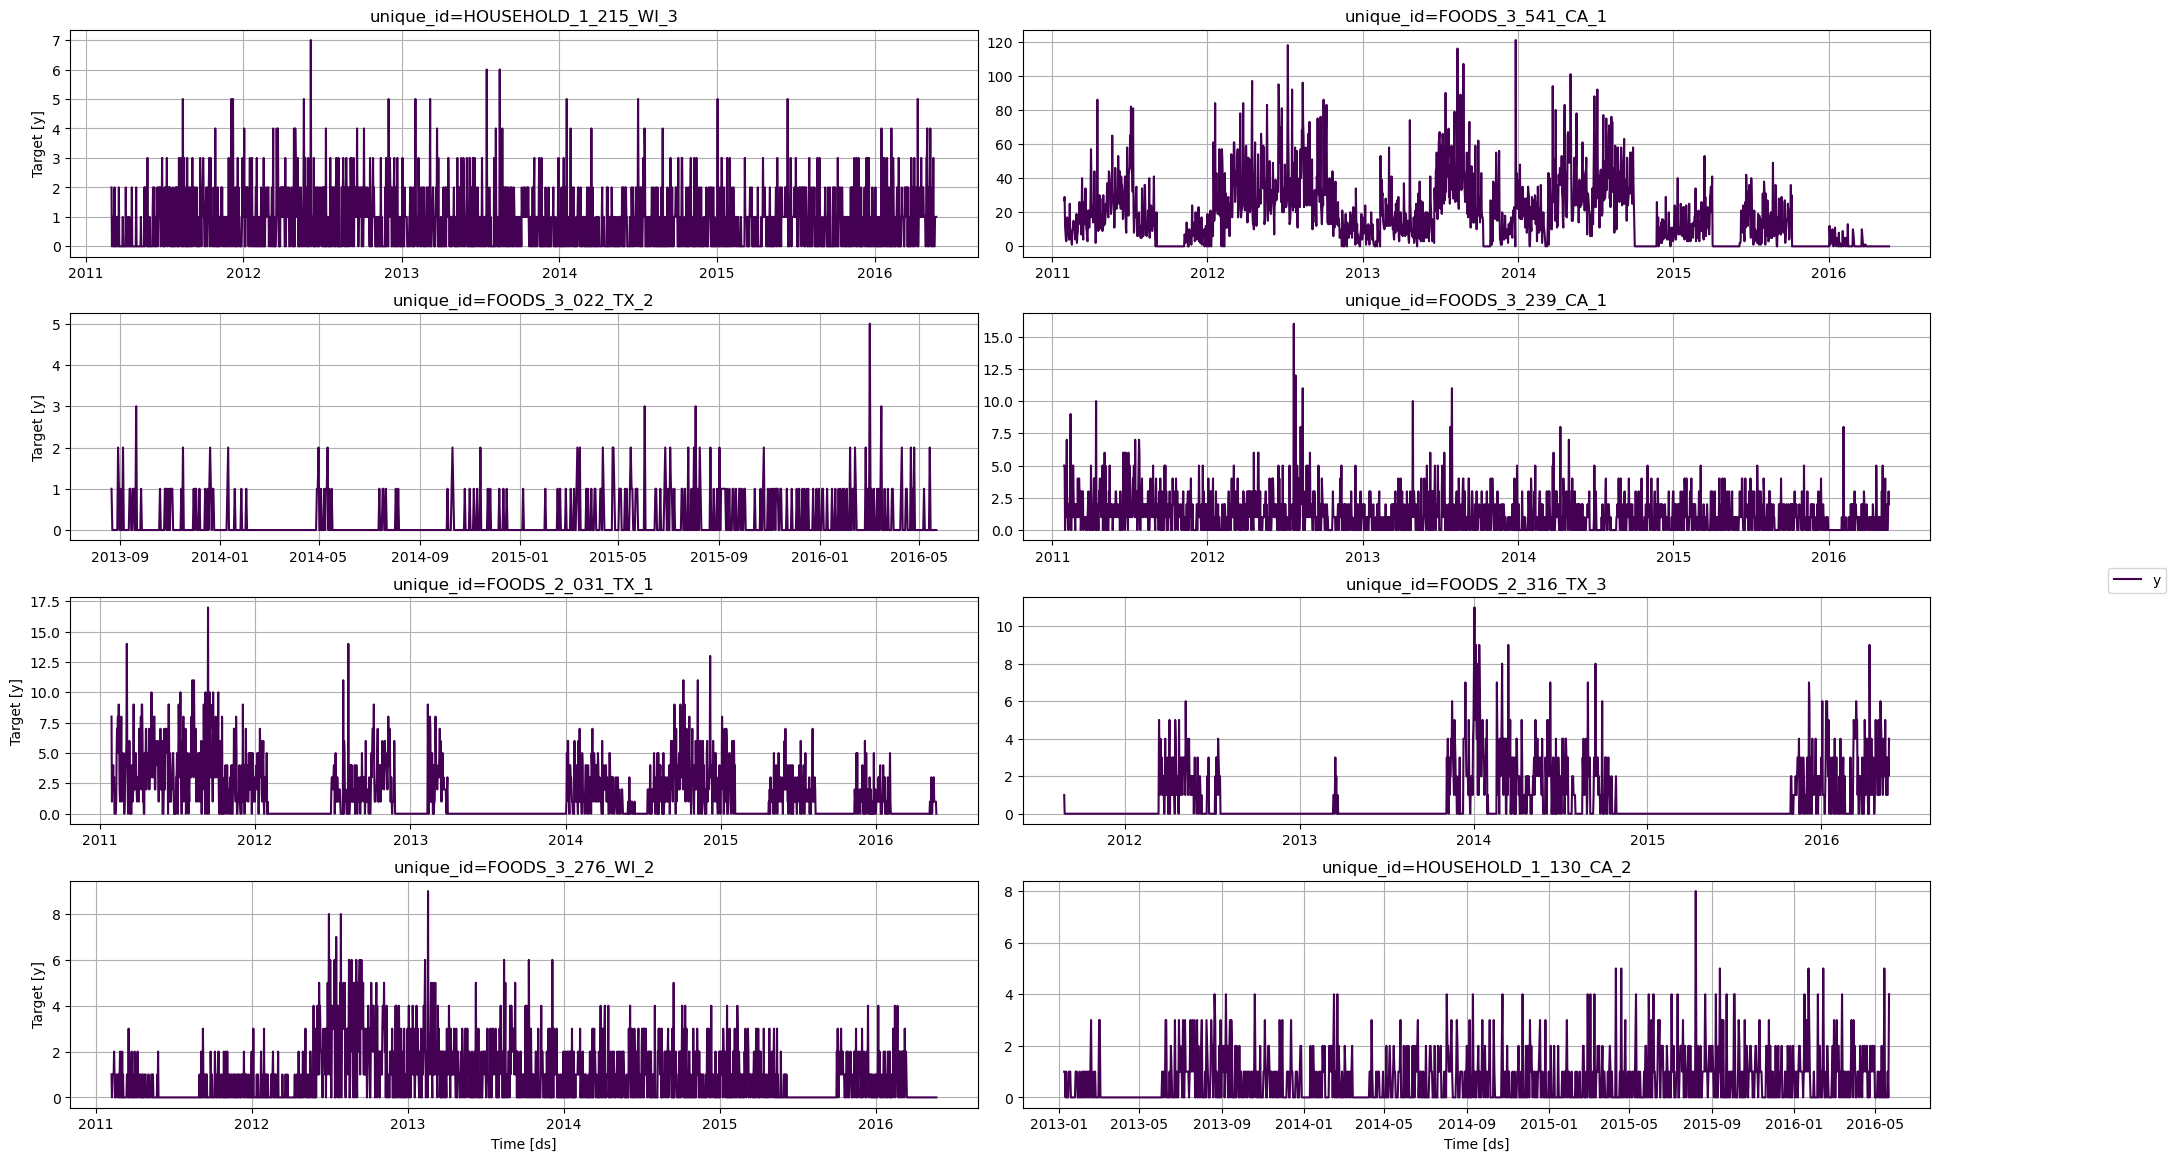

In [25]:
from utilsforecast.plotting import plot_series 

plot_series(Y_df)

## 2. Perform time series cross-validation

In [9]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoTFT, AutoDeepAR, AutoNBEATS
from neuralforecast.losses.pytorch import DistributionLoss

In [10]:
config_nhits = {
    "input_size": tune.choice([28, 28*2, 28*3, 28*5]),              # Length of input window
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[512, 512]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([32, 64, 128, 256]),                  # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),       # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_tft = {
        "input_size": tune.choice([28, 28*2, 28*3]),                # Length of input window
        "hidden_size": tune.choice([64, 128, 256]),                 # Size of embeddings and encoders
        "learning_rate": tune.loguniform(1e-4, 1e-2),               # Initial learning rate
        "scaler_type": tune.choice([None]),                         # Scaler type
        "max_steps": tune.choice([500, 1000]),                      # Max number of training iterations
        "batch_size": tune.choice([32, 64, 128, 256]),              # Number of series in batch
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),   # Number of windows in batch
        "random_seed": tune.randint(1, 20),                         # Random seed
    }

config_deepar = {
    "input_size": tune.choice([28, 28*2, 28*3]),                 
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "scaler_type": tune.choice([None]),
    "max_steps": tune.choice([500, 1000]),
    "batch_size": tune.choice([32, 64, 128, 256]),
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),
    "random_seed": tune.randint(1, 20),
    }



In [17]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2), 
        AutoDeepAR(h=28, config=config_deepar, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2)
    ],
    freq='D'
)

In [18]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=28)

(pid=69794) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=69794)   "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
(pid=69794) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=69794)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=69794) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=69794)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=69794) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFram

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  42%|████▏     | 100/239 [00:13<00:18,  7.61it/s, v_num=0, train_loss_step=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/239 [00:00<?, ?it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   0%|          | 1/239 [00:00<01:59,  2.00it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|          | 2/239 [00:01<01:58,  2.00it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|▏         | 3/239 [00:01<01:57,  2.02it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   2%|▏         | 4/239 [00:01<01:56,  2.01it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   2%|▏         | 5/239 [00:02<01:56,  2.02it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   3%|▎         | 6/239 [00:02<01:55,  2.02it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   3%|▎         | 7/239 [00:03<01:54,  2.03it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   3%|▎     

(_train_tune pid=69794) Seed set to 9


Epoch 0:  21%|██        | 100/477 [00:03<00:14, 26.40it/s, v_num=0, train_loss_step=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/477 [00:00<?, ?it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   0%|          | 1/477 [00:00<02:22,  3.34it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   0%|          | 2/477 [00:00<02:18,  3.42it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|          | 3/477 [00:00<02:18,  3.42it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|          | 4/477 [00:01<02:17,  3.44it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|          | 5/477 [00:01<02:16,  3.45it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|▏         | 6/477 [00:01<02:16,  3.46it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   1%|▏         | 7/477 [00:02<02:15,  3.46it/s]
(_train_tune pid=69794) 
Validation DataLoader 0:   2%|▏         | 8/477 [00:02<02:15,  3.47it/s]
(_train_tune p

Seed set to 9


(_train_tune pid=69794) 
Epoch 2:  10%|▉         | 46/477 [02:19<21:48,  0.33it/s, v_num=0, train_loss_step=1.120, valid_loss=0.471, train_loss_epoch=1.410]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=69794) /Users/marianamenchero/miniforge3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=69794)   warnings.warn('resource_tracker: There appear to be %d '


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
cv_df = cv_df.reset_index()
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoTFT,...,AutoTFT-lo-80,AutoTFT-hi-80,AutoTFT-hi-90,AutoDeepAR,AutoDeepAR-median,AutoDeepAR-lo-90,AutoDeepAR-lo-80,AutoDeepAR-hi-80,AutoDeepAR-hi-90,y
0,FOODS_1_001_CA_1,2016-02-29,2016-02-28,0.474,0.5,0.049999,0.000000,1.800049,0.950012,0.530,...,0.900002,0.099976,0.000000,0.57,0.0,0.0,0.0,1.0,2.0,1.0
1,FOODS_1_001_CA_1,2016-03-01,2016-02-28,0.511,0.0,0.000000,0.000000,0.000000,0.000000,0.613,...,0.000000,0.000000,1.950012,0.69,1.0,0.0,0.0,2.0,2.0,0.0
2,FOODS_1_001_CA_1,2016-03-02,2016-02-28,0.565,0.5,0.000000,0.900002,0.399902,0.000000,0.608,...,0.000000,0.000000,0.950012,0.60,0.0,0.0,0.0,2.0,2.0,1.0
3,FOODS_1_001_CA_1,2016-03-03,2016-02-28,0.504,0.0,0.000000,1.000000,1.800049,1.000000,0.617,...,0.099998,0.000000,0.049988,0.55,0.0,0.0,0.0,2.0,2.0,0.0
4,FOODS_1_001_CA_1,2016-03-04,2016-02-28,0.472,0.5,0.049999,1.099998,0.900024,0.000000,0.610,...,0.000000,0.000000,0.049988,0.61,0.0,0.0,0.0,2.0,2.0,0.0


In [32]:
#cv_df.to_csv('cv_df.csv', index=False) # this is a temporary line to load results locally without running the cross-validation again
cv_df = pd.read_csv('cv_df.csv')

NeuralForecast generates a point forecast, a median forecast, and 80 and 90% prediction intervals. In this tutorial, we'll use the median forecast, which represents the 50th percentile of the predicted distribution. 

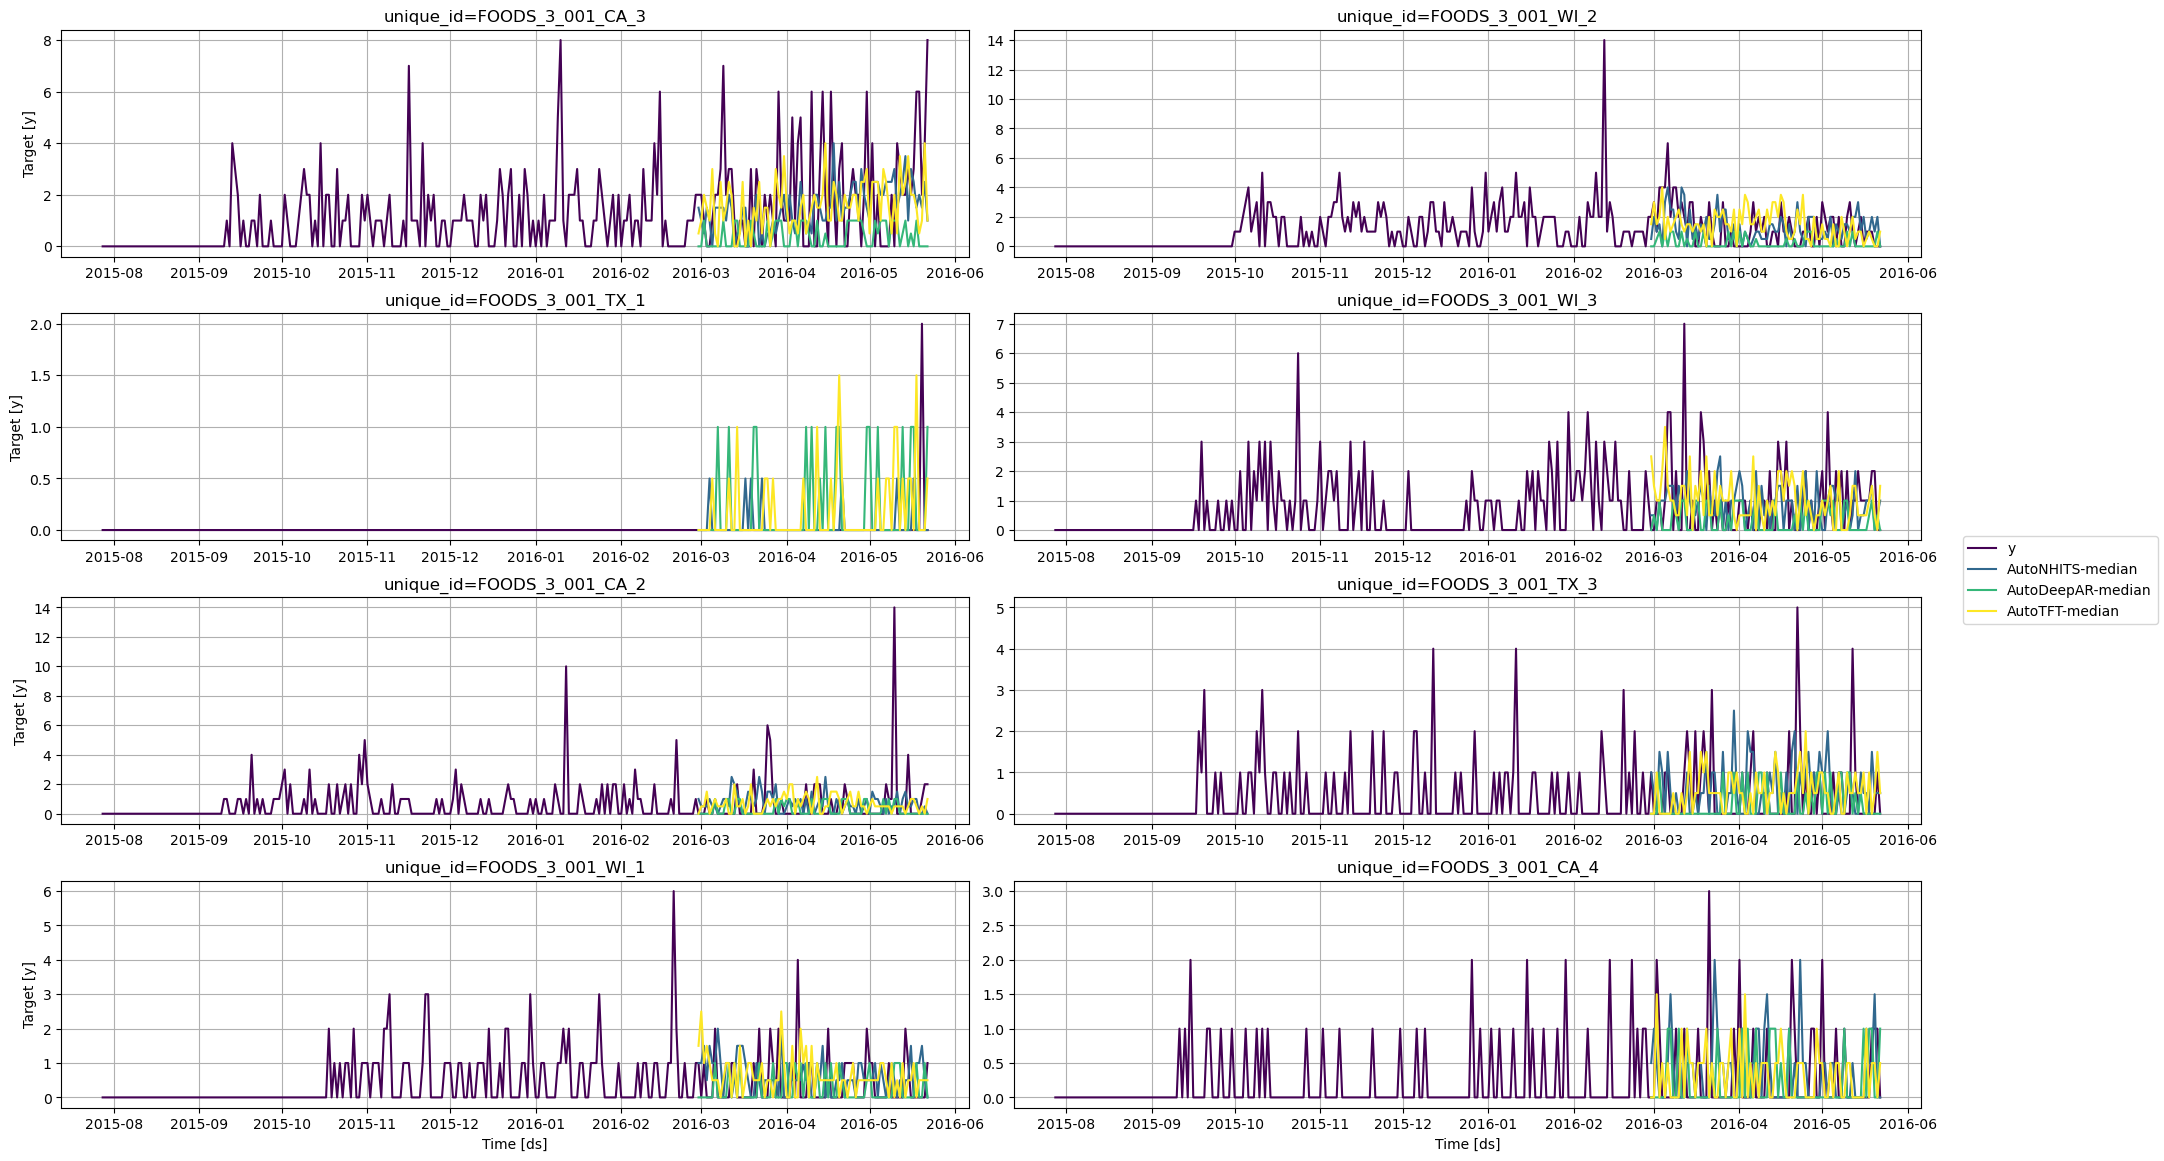

In [36]:
cv_df = cv_df[['unique_id', 'ds', 'cutoff', 'y', 'AutoNHITS-median', 'AutoDeepAR-median', 'AutoTFT-median']]

plot_series(Y_df, cv_df.drop(columns=['y', 'cutoff']), max_insample_length=300)